In [3]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

In [4]:
df = pd.read_csv('./data/fire_data_v2.csv', encoding='cp949')

In [62]:
# 지도에 그리드 그리는 함수
def get_geojson_grid(upper_right, lower_left, n=6):

    all_boxes = []

    lat_steps = np.linspace(lower_left[0], upper_right[0], n+1)
    lon_steps = np.linspace(lower_left[1], upper_right[1], n+1)

    lat_stride = lat_steps[1] - lat_steps[0]
    lon_stride = lon_steps[1] - lon_steps[0]

    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            # Define dimensions of box in grid
            upper_left = [lon, lat + lat_stride]
            upper_right = [lon + lon_stride, lat + lat_stride]
            lower_right = [lon + lon_stride, lat]
            lower_left = [lon, lat]

            # Define json coordinates for polygon
            coordinates = [
                upper_left,
                upper_right,
                lower_right,
                lower_left,
                upper_left
            ]

            geo_json = {"type": "FeatureCollection",
                        "properties":{
                            "lower_left": lower_left,
                            "upper_right": upper_right
                        },
                        "features":[]}

            grid_feature = {
                "type":"Feature",
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [coordinates],
                }
            }

            geo_json["features"].append(grid_feature)

            all_boxes.append(geo_json)

    return all_boxes

In [63]:
# 부여 동서남북 가장 끝 좌표
LOWER = 36.0721
LEFT = 126.6796
UPPER = 36.3865
RIGHT = 127.07

In [5]:
# 화재 원인별 화재 분류
# 임야는 추가 데이터 없으므로 이 화재정보를 이용해 임야 판별 + 좌표별 노인인구지수이용
# 주택은 
df['화재구분'].value_counts()

임야       418
주택       397
비닐하우스    162
자동차      124
창고       119
쓰레기      114
상가       107
축사        69
기타        66
공장        46
균사        25
Name: 화재구분, dtype: int64

In [67]:
# 좌표 벗어나는 데이터 쳐내기
df_clean = df.loc[:, ["화재발생년월일", "대상(도로)명", "화재구분","최종_경도", "최종_위도"]]
df_clean = df_clean.drop(df_clean[df_clean['최종_경도'] == 0].index)
df_clean = df_clean.drop(df_clean[df_clean['최종_경도'] < LEFT].index)
df_clean = df_clean.drop(df_clean[df_clean['최종_경도'] > RIGHT].index)
df_clean = df_clean.drop(df_clean[df_clean['최종_위도'] < LOWER].index)
df_clean = df_clean.drop(df_clean[(df_clean['최종_위도'] > UPPER)].index)
df_clean.reset_index(inplace=True)
df_clean.head()

,index,화재발생년월일,대상(도로)명,화재구분,최종_경도,최종_위도
0,0,2012-01-02 10:23,동식물시설(견사),축사,126.892854,36.182266
1,1,2012-01-02 19:58,건축구조물(단독주택),주택,126.906522,36.283769
2,2,2012-01-03 17:40,위락시설-유흥주점(베네치아),상가,126.870201,36.273447
3,3,2012-01-04 22:59,주거시설-단독주택,주택,126.885429,36.157451
4,4,2012-01-06 0:57,주거시설-단독주택,주택,126.862228,36.190490


In [68]:
# 위도, 경도 15, 15 좌표계로 변환
df_clean['x'] = df_clean['최종_경도'].astype(float).map(lambda x: np.trunc((x - LEFT) / ((RIGHT - LEFT) / 15.)))
df_clean['y'] = df_clean['최종_위도'].astype(float).map(lambda x: np.trunc((x - LOWER) / ((UPPER - LOWER) / 15.)))
df_clean.head()

,index,화재발생년월일,대상(도로)명,화재구분,최종_경도,최종_위도,x,y
0,0,2012-01-02 10:23,동식물시설(견사),축사,126.892854,36.182266,8.0,5.0
1,1,2012-01-02 19:58,건축구조물(단독주택),주택,126.906522,36.283769,8.0,10.0
2,2,2012-01-03 17:40,위락시설-유흥주점(베네치아),상가,126.870201,36.273447,7.0,9.0
3,3,2012-01-04 22:59,주거시설-단독주택,주택,126.885429,36.157451,7.0,4.0
4,4,2012-01-06 0:57,주거시설-단독주택,주택,126.862228,36.190490,7.0,5.0


In [69]:
# 화재발생년월일을 년, 월, 일 컬럼으로 분해
df_clean['년'] = pd.to_datetime(df_clean['화재발생년월일']).dt.year
df_clean['월'] = pd.to_datetime(df_clean['화재발생년월일']).dt.month
df_clean['일'] = pd.to_datetime(df_clean['화재발생년월일']).dt.day
df_clean.head()

,index,화재발생년월일,대상(도로)명,화재구분,최종_경도,최종_위도,x,y,년,월,일
0,0,2012-01-02 10:23,동식물시설(견사),축사,126.892854,36.182266,8.0,5.0,2012,1,2
1,1,2012-01-02 19:58,건축구조물(단독주택),주택,126.906522,36.283769,8.0,10.0,2012,1,2
2,2,2012-01-03 17:40,위락시설-유흥주점(베네치아),상가,126.870201,36.273447,7.0,9.0,2012,1,3
3,3,2012-01-04 22:59,주거시설-단독주택,주택,126.885429,36.157451,7.0,4.0,2012,1,4
4,4,2012-01-06 0:57,주거시설-단독주택,주택,126.862228,36.190490,7.0,5.0,2012,1,6


In [70]:
df_clean = df_clean.loc[:, ['년', '월', '일', 'x', 'y', '최종_위도', '최종_경도', '화재구분']]
df_clean.head()

,년,월,일,x,y,최종_위도,최종_경도,화재구분
0,2012,1,2,8.0,5.0,36.182266,126.892854,축사
1,2012,1,2,8.0,10.0,36.283769,126.906522,주택
2,2012,1,3,7.0,9.0,36.273447,126.870201,상가
3,2012,1,4,7.0,4.0,36.157451,126.885429,주택
4,2012,1,6,7.0,5.0,36.190490,126.862228,주택


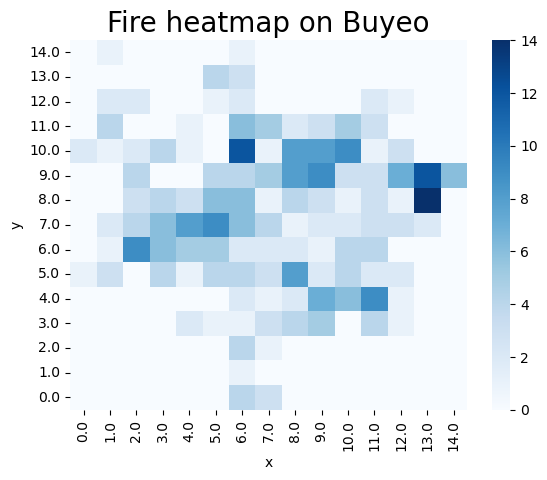

In [73]:
# 임야화재 발생 빈도 파악
df_lat_lon = df_clean[(df_clean['화재구분'] == '임야')].loc[:, ["x", "y"]]
fire_heatmap = df_lat_lon.loc[:, ['y', 'x']].groupby(['y', 'x'])['x'].count().unstack().sort_index(ascending=False).fillna(0)
ax = sns.heatmap(fire_heatmap, cmap='Blues')
plt.title('Fire heatmap on Buyeo', fontsize=20)
plt.show()

In [79]:
# 지도에 화재 발생 데이터 표시
df_lat_lon = df_clean.loc[:, ["최종_위도","최종_경도"]]
m = folium.Map(location=((LOWER + UPPER) / 2, (LEFT + RIGHT) / 2), zoom_start=10)

upper_right = [UPPER, RIGHT]
lower_left = [LOWER, LEFT]

grid = get_geojson_grid(upper_right, lower_left , n=15)

for i, geo_json in enumerate(grid):

    color = plt.cm.Reds(1)
    color = mpl.colors.to_hex(color)

    gj = folium.GeoJson(geo_json,
                        style_function=lambda feature, color=color: {
                                                                        'fillColor': color,
                                                                        'color':"black",
                                                                        'weight': 2,                                                                      
                                                                        'fillOpacity': 0.3,
                                                                    })
    popup = folium.Popup("example popup {}".format(i))
    gj.add_child(popup)

    m.add_child(gj)

for i in df_lat_lon.index:
    folium.Circle([df_lat_lon.loc[i, "최종_위도"], df_lat_lon.loc[i, "최종_경도"]], ).add_to(m)

m

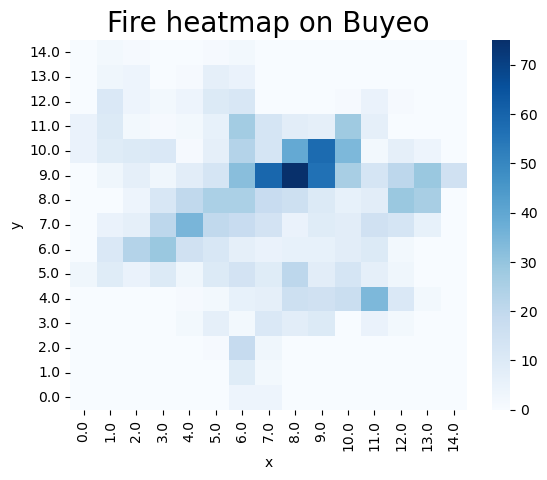

In [80]:
fire_heatmap = df_clean.loc[:, ['y', 'x']].groupby(['y', 'x'])['x'].count().unstack().sort_index(ascending=False).fillna(0)
ax = sns.heatmap(fire_heatmap, cmap='Blues')
plt.title('Fire heatmap on Buyeo', fontsize=20)
plt.show()

In [14]:
# 월일 별 화재 발생 데이터 분석
df_date = df.loc[:, "화재발생년월일"].dropna()

<AxesSubplot:>

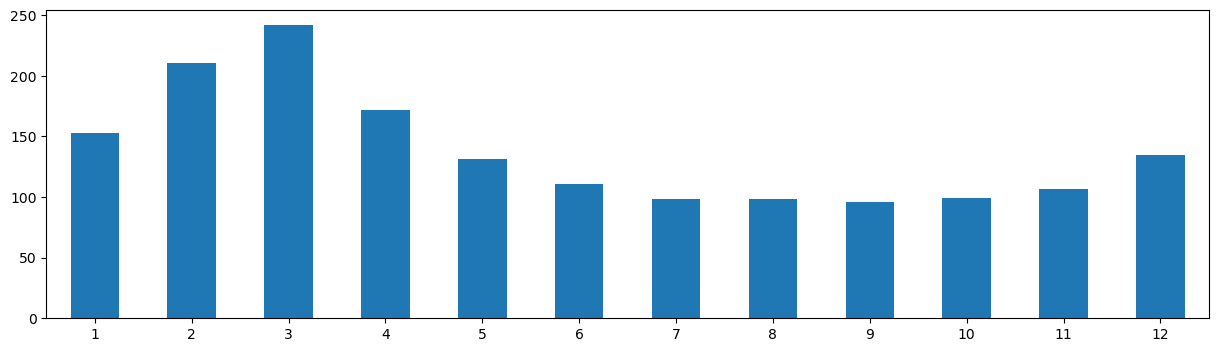

In [15]:
pd.to_datetime(df_date).dt.month.value_counts().sort_index().plot.bar(figsize=(15, 4), rot=0)

<AxesSubplot:>

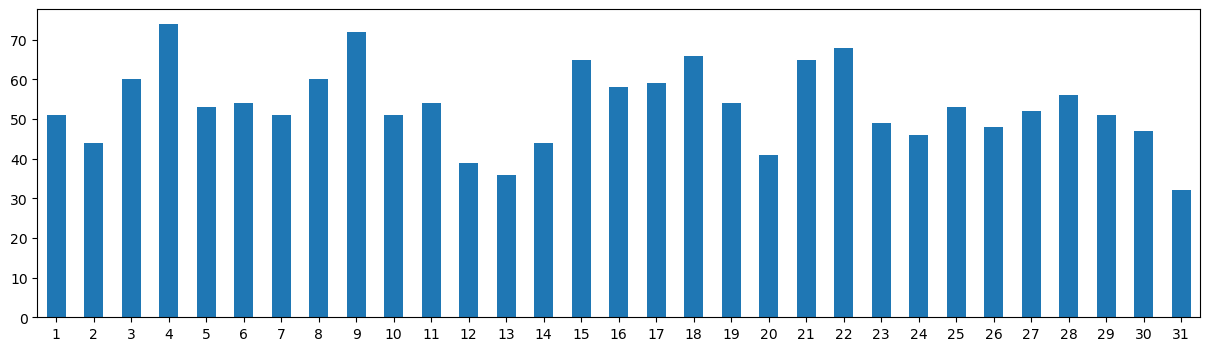

In [16]:
pd.to_datetime(df_date).dt.day.value_counts().sort_index().plot.bar(figsize=(15, 4), rot=0)

In [82]:
# 데이터 저장
df_clean.to_csv('./data/preprocessed_fire_data.csv', encoding='utf-8-sig', index=False)